### Calculate wetness, brightness and greenness according to Roberts 2017; plot, choose a threshold, and output WBG layers to geotiff for VRT assemblage in  QGIS.

### 06-11-2017 BD

## import some modules

In [2]:
#for writing to error files:
from __future__ import print_function
#get some libraries
import datacube
import xarray as xr
from datacube.storage import masking
#from datacube.storage.masking import mask_to_dict #think this is obsolete
import json
import pandas as pd
import shapely
from shapely.geometry import shape
import numpy as np #need this for pq fuser

#libraries for polygon and polygon mask
import fiona
import shapely.geometry
import rasterio.features
import rasterio
from datacube.utils import geometry
from datacube.helpers import ga_pq_fuser
from datacube.storage.masking import mask_invalid_data

#for writing to netcdf
from datacube.storage.storage import write_dataset_to_netcdf
#dealing with system commands
import sys
import os.path

#####These not needed for raijin::::
import matplotlib.pyplot as plt
import matplotlib as mpl

#suppress warnings thrown when using inequalities in numpy (the threshold values!)
import warnings

#import module to work with rgb images
from PIL import Image

def eprint(*args, **kwargs):
    print(*args, file=sys.stderr, **kwargs)
        
    

## define functions to load nbart, calculate wetness, wetness over threshold, counts, and write datasets to netcdf

In [3]:
def load_nbart(sensor,query,bands_of_interest): 
    '''loads nbart data for a sensor, masks using pq, then filters out terrain -999s
    function written 23-08-2017 based on dc v1.5.1'''  
    dataset = []
    product_name = '{}_{}_albers'.format(sensor, 'nbart')
    print('loading {}'.format(product_name))
    ds = dc.load(product=product_name, measurements=bands_of_interest,
                 group_by='solar_day', **query)
    #grab crs defs from loaded ds if ds exists
    if ds:
        crs = ds.crs
        affine = ds.affine
        print('loaded {}'.format(product_name))
        mask_product = '{}_{}_albers'.format(sensor, 'pq')
        sensor_pq = dc.load(product=mask_product, fuse_func=ga_pq_fuser,
                            group_by='solar_day', **query)
        if sensor_pq:
            print('making mask {}'.format(mask_product))
            cloud_free = masking.make_mask(sensor_pq.pixelquality,
                                           cloud_acca='no_cloud',
                                           cloud_shadow_acca = 'no_cloud_shadow',                           
                                           cloud_shadow_fmask = 'no_cloud_shadow',
                                           cloud_fmask='no_cloud',
                                           blue_saturated = False,
                                           green_saturated = False,
                                           red_saturated = False,
                                           nir_saturated = False,
                                           swir1_saturated = False,
                                           swir2_saturated = False,
                                           contiguous=True)
            ds = ds.where(cloud_free)
            ds.attrs['crs'] = crs
            ds.attrs['affine'] = affine
            print('masked {} with {} and filtered terrain'.format(product_name,mask_product))
            # nbarT is correctly used to correct terrain by replacing -999.0 with nan
            ds=ds.where(ds!=-999.0)
        else: 
            print('did not mask {} with {}'.format(product_name,mask_product))
    else:
        print ('did not load {}'.format(product_name)) 

    if len(ds)>0:
        return ds
    else:
        return None

### define wetness function

In [4]:
#calculating tasselled cap wetness
def calc_wetness(sensor_data,sensor):
    '''This function performs the tasselled cap transformation, multiplying band data by tasselled cap coefficients to 
    produce a "wetness" "band".
    sensor_data is surface reflectance data loaded from the datacube
    sensor = 'ls5, 'ls7' or 'ls8'
    Coefficients are from Roberts 2018 in press
    function written 23-08-2017 based on dc v1.5.1. updated 06-11-2017 bd'''
    
    wetness_coeff = {'ls5':{'blue':0.5702, 'green': 0.1584, 'red':0.2627, 'nir':-0.3959, 'swir1':-0.0045, 'swir2':-0.6511},
                    'ls7':{'blue':0.5702, 'green': 0.1584, 'red':0.2627, 'nir':-0.3959, 'swir1':-0.0045, 'swir2':-0.6511},
                    'ls8':{'blue':0.5702, 'green': 0.1584, 'red':0.2627, 'nir':-0.3959, 'swir1':-0.0045, 'swir2':-0.6511}}  
    #if there is sensor data for the time period
    if sensor_data is not None: 
         # make a deep copy of the sensor data
        wbg = sensor_data.copy(deep=True)
        #iterate over the spectral bands
        for band_name in sensor_data.data_vars:
            #multiply each band by the transform coefficient to get a band-specific value
            wetness_band = sensor_data[band_name]*wetness_coeff[sensor][band_name]
            #update the existing band data with the TC data
            #by making new bands, called wet_green, bright_green etc.
            wbg.update({'wet_'+band_name:(['time','y','x'],wetness_band)})
            #then drop the original bands
            wbg = wbg.drop({band_name})    
        #sum the values for each band to get the tcw dim    
        wbg['wetness']=wbg.wet_blue+wbg.wet_green+wbg.wet_red+wbg.wet_nir+wbg.wet_swir1+wbg.wet_swir2
        bands_to_drop =[]
        for new_band in wbg.data_vars:
            bands_to_drop.append(new_band)            
        bands_to_drop.remove('wetness')    
        wbg = wbg.drop(bands_to_drop)
        print('calculated wetness for {}'.format(sensor))
        return wbg    
    else:
        print('did not calculate wetness for {}'.format(sensor))
        return None            

### define brightness function

In [5]:
#calculating tasselled cap brightness
def calc_brightness(sensor_data,sensor):
    '''This function performs the tasselled cap transformation, multiplying band data by tasselled cap coefficients to 
    produce a "brightness" "band".
    sensor_data is surface reflectance data loaded from the datacube
    sensor = 'ls5, 'ls7' or 'ls8'
    Coefficients are from Roberts 2018 in press
    function written 23-08-2017 based on dc v1.5.1. updated 06-11-2017 bd'''

    brightness_coeff = {'ls5':{'blue':0.3567, 'green':0.3567, 'red':0.3567, 'nir':0.535, 'swir1':0.535, 'swir2':0.214},
                    'ls7':{'blue':0.3567, 'green':0.3567, 'red':0.3567, 'nir':0.535, 'swir1':0.535, 'swir2':0.214},
                    'ls8':{'blue':0.3567, 'green':0.3567, 'red':0.3567, 'nir':0.535, 'swir1':0.535, 'swir2':0.214}}
#if there is sensor data for the time period
    if sensor_data is not None: 
        wbg = sensor_data.copy(deep=True)
        #iterate over the spectral bands
        for band_name in sensor_data.data_vars:
            #multiply each band by the transform coefficient to get a band-specific value
            brightness_band = sensor_data[band_name]*brightness_coeff[sensor][band_name]
            #update the existing band data with the TC data
            #by making new bands, called bright_green etc.
            #then drop the original bands
            wbg.update({'bright_'+band_name:(['time','y','x'],brightness_band)})
            wbg = wbg.drop({band_name})    
        wbg['brightness']=wbg.bright_blue+wbg.bright_green+wbg.bright_red+wbg.bright_nir+wbg.bright_swir1+wbg.bright_swir2   
        bands_to_drop =[]
        for new_band in wbg.data_vars:
            bands_to_drop.append(new_band)            
        bands_to_drop.remove('brightness')
        wbg = wbg.drop(bands_to_drop)
        print('calculated brightness for {}'.format(sensor))
        return wbg    
    else:
        print('did not calculate brightness for {}'.format(sensor))
        return None        #calculating tasselled cap brightness

### define greennness function

In [6]:
#calculating tasselled cap greenness
def calc_greenness(sensor_data,sensor):
    '''This function performs the tasselled cap transformation, multiplying band data by tasselled cap coefficients to 
    produce a "brightness" "band".
    sensor_data is surface reflectance data loaded from the datacube
    sensor = 'ls5, 'ls7' or 'ls8'
    Coefficients are from Roberts 2018 in press
    function written 23-08-2017 based on dc v1.5.1. updated 06-11-2017 bd'''

    greenness_coeff = {'ls5':{'blue':-0.1987, 'green':-0.2826, 'red':-0.2724, 'nir':0.5357, 'swir1':0.2388, 'swir2':-0.68},
                       'ls7':{'blue':-0.1987, 'green':-0.2826, 'red':-0.2724, 'nir':0.5357, 'swir1':0.2388, 'swir2':-0.68},
                       'ls8':{'blue':-0.1987, 'green':-0.2826, 'red':-0.2724, 'nir':0.5357, 'swir1':0.2388, 'swir2':-0.68}}  
   #if there is sensor data for the time period
    if sensor_data is not None: 
        wbg = sensor_data.copy(deep=True)
        #iterate over the spectral bands
        for band_name in sensor_data.data_vars:
            #multiply each band by the transform coefficient to get a band-specific value
            greenness_band = sensor_data[band_name]*greenness_coeff[sensor][band_name]
            #update the existing band data with the TC data
            #by making new bands, called bright_green etc.
            #then drop the original bands
            wbg.update({'green_'+band_name:(['time','y','x'],greenness_band)})
            wbg = wbg.drop({band_name})    
        wbg['greenness']=wbg.green_blue+wbg.green_green+wbg.green_red+wbg.green_nir+wbg.green_swir1+wbg.green_swir2   
        bands_to_drop =[]
        for new_band in wbg.data_vars:
            bands_to_drop.append(new_band)            
        bands_to_drop.remove('greenness')
        wbg = wbg.drop(bands_to_drop)
        print('calculated greenness for {}'.format(sensor))
        return wbg    
    else:
        print('did not calculate greenness for {}'.format(sensor))
        return None        

## set thresholds here for wet, bright, and green

In [7]:
def calc_wetness_overthresh(wetness,threshold=-600):
    '''Calculate the wetness values where wetness>threshold. Inputs are wetness array and threshold value, 
    default threshold is -400. Band for wetness>threshold is added to wetness. This is not the count.'''
    if wetness is not None:
        with warnings.catch_warnings():
            #suppress irritating behaviour in xarray.where
            warnings.simplefilter("ignore")
            wetness['wetness_over_threshold'] = wetness.wetness.where(wetness.wetness>threshold)
            print('thresholded wetness added to array')
            return wetness
    else:
        print('did not calculate wetness over threshold' )
        return None    

In [8]:
def calc_brightness_overthresh(brightness,threshold=4000):
    '''Calculate the brightness values where brightnesss>threshold. Inputs are brightness array and threshold value, 
    default threshold is -400. Band for brightness>threshold is added to brightness. This is not the count.'''
    if brightness is not None:
        with warnings.catch_warnings():
            #suppress irritating behaviour in xarray.where
            warnings.simplefilter("ignore")
            brightness['brightness_over_threshold'] = brightness.brightness.where(brightness.brightness>threshold)
            print('thresholded brightness added to array')
            return brightness
    else:
        print('did not calculate brightness over threshold' )
        return None  

In [9]:
def calc_greenness_overthresh(greenness,threshold=600):
    '''Calculate the wetness values where wetness>threshold. Inputs are wetness array and threshold value, 
    default threshold is -400. Band for wetness>threshold is added to wetness. This is not the count.'''
    if greenness is not None:
        with warnings.catch_warnings():
            #suppress irritating behaviour in xarray.where
            warnings.simplefilter("ignore")
            greenness['greenness_over_threshold'] = greenness.greenness.where(greenness.greenness>threshold)
            print('thresholded greenness added to array')
            return greenness
    else:
        print('did not calculate greenness over threshold' )
        return None  

##### this section under development - re-write over threshold count function

### define function to count a TC index (bright/wet/green) (for one sensor)

In [10]:
def count_tcindex_1sensor(over_threshold, tcindex, tci_over_threshold):
    '''count the number of tci-flagged scenes for each pixel,
    count the amount of times that tci value is above the set threshold
    load both into memory (this assumes you are using dask),
    return a dictionary of total count and threshold count
    ###FIXME currently only runs over 1 sensor!!!'''
    if over_threshold is not None:
        #count the number of flagged scenes for each pixel
        total_count = over_threshold[tcindex].count(dim='time')

        #count the amount of times that water plus wet veg is above the threshold
        threshold_count= over_threshold[tci_over_threshold].count(dim='time')
       
        #define dictionary of total count and threshold count
        counts = {'total count':total_count, 'threshold count':threshold_count}
        
        count_of_ex = counts['threshold count']/counts['total count']
        print('counted')
        return count_of_ex, counts
    else:
        print('did not count')
        return None      

### function to write netcdf

In [11]:
def write_your_netcdf(data, dataset_name, filename,crs):
    '''this function turns an xarray dataarray into a dataset so we can write it to netcdf. It adds on a crs definition
    from the original array. data = your xarray dataset, dataset_name is a string describing your variable'''    
    #turn array into dataset so we can write the netcdf
    dataset= data.to_dataset(name=dataset_name)
    #grab our crs attributes to write a spatially-referenced netcdf
    dataset.attrs['crs'] = crs
    #dataset.dataset_name.attrs['crs'] = crs
    try:
        write_dataset_to_netcdf(dataset, filename)
    except RuntimeError as err:
        print("RuntimeError: {0}".format(err))        

#### save netcdf outputs to this folder:

In [12]:
#netcdf_output_loc ='/g/data/r78/rjd547/groundwater_activities/Analysis/'
netcdf_output_loc ='/g/data/r78/rjd547/groundwater_activities/Analysis/TCW_stats/'

#### code to work with a polygon input

In [13]:
#code to work with a polygon input
#shape_file = ('/g/data/r78/rjd547/groundwater_activities/Whole_NA/WholeNA_shapes/Kevin.shp')
shape_file = ('/g/data/r78/rjd547/groundwater_activities/Whole_NA/WholeNA_shapes/small_shapes/lake_gregory_sml.shp')
# open all the shapes within the shape file
shapes = fiona.open(shape_file)
i =0 
print('shapefile index is '+str(i))
if i > len(shapes):
    print('index not in the range for the shapefile'+str(i)+' not in '+str(len(shapes)))
    sys.exit(0)
#copy attributes from shapefile and define shape_name
geom_crs = geometry.CRS(shapes.crs_wkt)
geo = shapes[i]['geometry']
geom = geometry.Geometry(geo, crs=geom_crs)
geom_bs = shapely.geometry.shape(shapes[i]['geometry'])
shape_name = shape_file.split('/')[-1].split('.')[0]+'_'+str(i)

shapefile index is 0


### set up the datacube query

In [14]:
#alias the datacube to something more wieldy and pass a string for reporting purposes
dc = datacube.Datacube(app='dc-nbart-tct')

#pick a time range
start_of_epoch = '2014-01-01'
end_of_epoch =  '2017-12-31'

#Define wavelengths/bands of interest, remove this kwarg to retrieve all bands
bands_of_interest = ['blue',
                     'green',
                     'red',
                     'nir',
                     'swir1',
                     'swir2'
                     ]

query = {
    'time': (start_of_epoch, end_of_epoch), 'geopolygon': geom,
}

### Load data for each sensor and apply cloud and terrain filters

In [15]:
#this is done separately instead of in a loop because the datasets can be quite large.
#currently this is a way of memory handling -there is probably a better way of doing it.
#sensor1_nbart=load_nbart('ls5',query,bands_of_interest)
#sensor2_nbart=load_nbart('ls7',query,bands_of_interest)
sensor3_nbart=load_nbart('ls8',query,bands_of_interest)

loading ls8_nbart_albers
loaded ls8_nbart_albers
making mask ls8_pq_albers
masked ls8_nbart_albers with ls8_pq_albers and filtered terrain


### Calculate wetness for each timeslice

In [16]:
#run the tcw transform on the surface reflectance data
#wetness_sensor1_nbart=calc_wetness(sensor1_nbart,'ls5')
#wetness_sensor2_nbart=calc_wetness(sensor2_nbart,'ls7')
wetness_sensor3_nbart=calc_wetness(sensor3_nbart,'ls8')

calculated wetness for ls8


### Calculate brightness for each timeslice

In [17]:
#run the tcw transform on the surface reflectance data
#wetness_sensor1_nbart=calc_wetness(sensor1_nbart,'ls5')
#wetness_sensor2_nbart=calc_wetness(sensor2_nbart,'ls7')
brightness_sensor3_nbart=calc_brightness(sensor3_nbart,'ls8')

calculated brightness for ls8


### Calculate greenness for each timeslice

In [18]:
#run the tcg transform on the surface reflectance data
#greenness_sensor1_nbart=calc_greenness(sensor1_nbart,'ls5')
#greenness_sensor2_nbart=calc_greenness(sensor2_nbart,'ls7')
greenness_sensor3_nbart=calc_greenness(sensor3_nbart,'ls8')

calculated greenness for ls8


## Calculate brightness count of exceedence 

In [19]:
brightness_sensor3_nbart.brightness.mean()

<xarray.DataArray 'brightness' ()>
array(4640.980609518215)

In [20]:
bright_overthresh =calc_brightness_overthresh(brightness_sensor3_nbart)

thresholded brightness added to array


In [21]:
brightness_count_of_ex_sensor3,counts_sensor_3_nbart = count_tcindex_1sensor(bright_overthresh, 'brightness','brightness_over_threshold')

counted


## Plot brightness count of exceedence

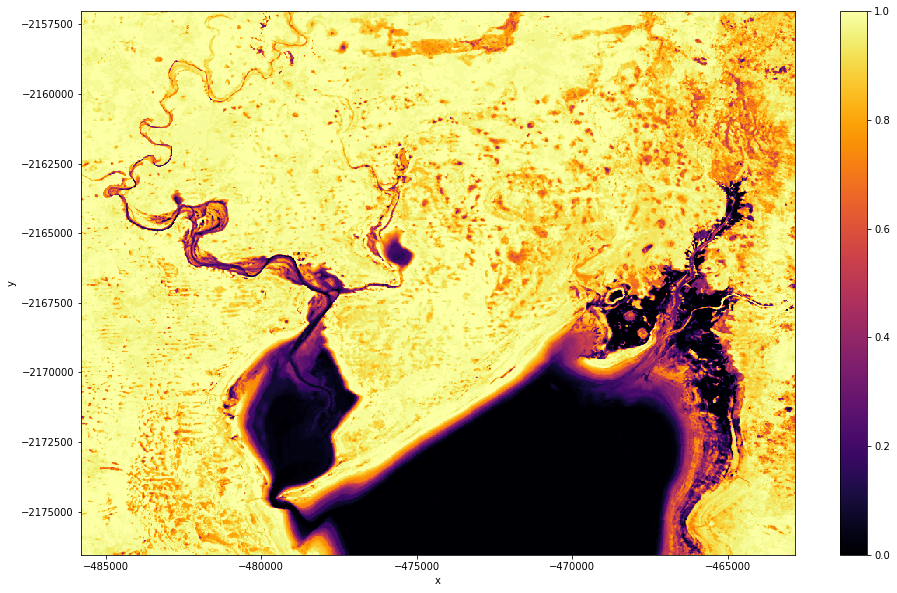

In [22]:
plt.clf()
plt.figure(figsize=(16,10))
brightness_count_of_ex_sensor3.plot(cmap='inferno')
plt.show()

## Calculate greenness count of exceedence

In [23]:
greenness_sensor3_nbart.greenness.mean()

<xarray.DataArray 'greenness' ()>
array(-545.884303281379)

In [24]:
green_overthresh = calc_greenness_overthresh(greenness_sensor3_nbart)

thresholded greenness added to array


In [25]:
greenness_count_of_ex_sensor3,gcounts_sensor_3_nbart = count_tcindex_1sensor(green_overthresh, 'greenness','greenness_over_threshold')

counted


## Plot greenness count of exceedence

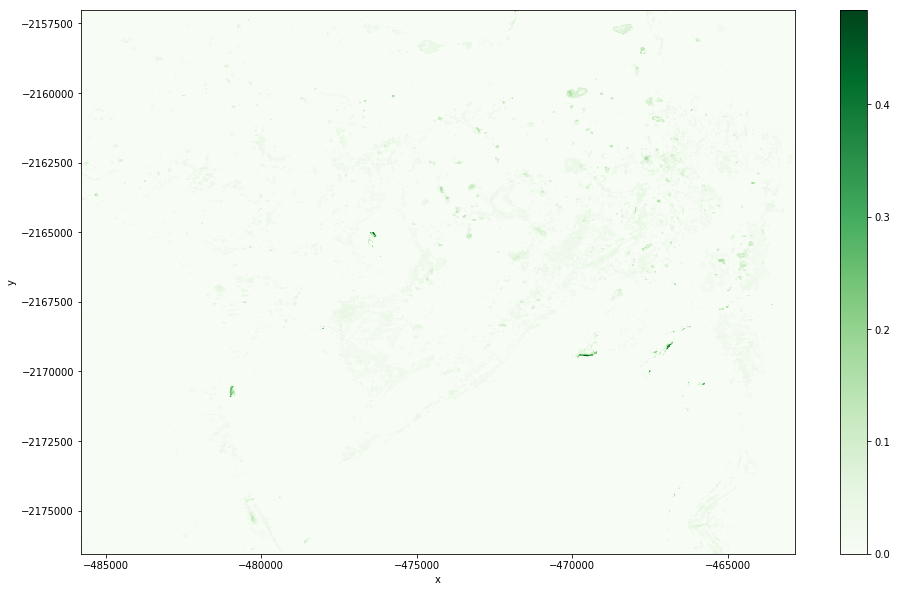

In [26]:
plt.clf()
plt.figure(figsize=(16,10))
greenness_count_of_ex_sensor3.plot(cmap='Greens')
plt.show()

## Calculate wetness count of exceedence

In [27]:
wetness_sensor3_nbart.wetness.mean()

<xarray.DataArray 'wetness' ()>
array(-1425.529170946911)

In [28]:
wet_overthresh = calc_wetness_overthresh(wetness_sensor3_nbart)

thresholded wetness added to array


In [29]:
wetness_count_of_ex_sensor3,wcounts_sensor_3_nbart = count_tcindex_1sensor(wet_overthresh, 'wetness','wetness_over_threshold')

counted


## Plot wetness count of exceedence

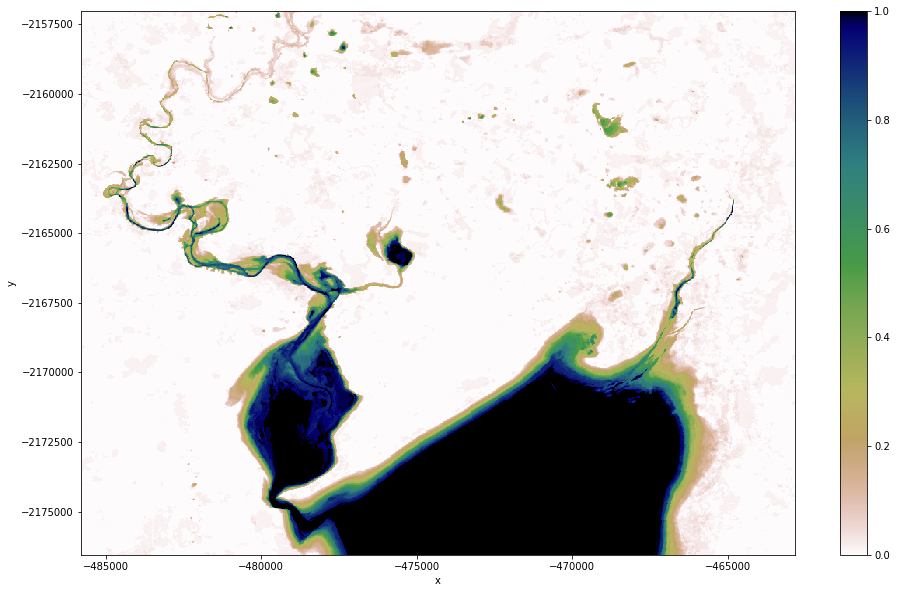

In [30]:
plt.clf()
plt.figure(figsize=(16,10))
wetness_count_of_ex_sensor3.plot(cmap='gist_earth_r')
plt.show()

In [31]:
# if sensor1_nbart is not None:
#     crs = sensor1_nbart.crs
# else:
#     if sensor2_nbart is not None:
#         crs = ensor2_nbart.crs
#     else: 
crs = sensor3_nbart.crs
print(crs) 

EPSG:3577


## Write out CoE arrays to netcdf

In [32]:
##### choose a filename

In [33]:
# #check if the file has already been written:
filenamestart = netcdf_output_loc+shape_name

In [34]:
write_your_netcdf(wetness_count_of_ex_sensor3,'tcw_ls8',filename=filenamestart+'_wetness_-600'+'.nc', crs=crs)

In [35]:
write_your_netcdf(brightness_count_of_ex_sensor3,'tcb_ls8',filename=filenamestart+'_brightness_4000'+'.nc', crs=crs)

In [36]:
write_your_netcdf(greenness_count_of_ex_sensor3,'tcg_ls8',filename=filenamestart+'_greenness_600'+'.nc', crs=crs)

In [37]:
os.chdir('/g/data/r78/rjd547/groundwater_activities/Analysis/TCW_stats/')

In [38]:
os.listdir()

['slice_0NoPizza.nc',
 'kakadu_test_2.vrt',
 'kakadu_sml_0_brightness_4000.nc',
 'vic_river_small_0_brightness_4000.nc',
 'kakadu_sml_0_greenness_600.nc',
 'kinrara_bs_0_wetness_-600.nc',
 'new_moon_inlet_0_wetness_-600.nc',
 'new_moon_sml_0_greenness_600.nc',
 'arafura_sw_0_greenness_600.nc',
 'arafura_sml_0_brightness_4000.nc',
 'arafura_sml_0_greenness_600.nc',
 'vic_river_small_0_greenness_600.nc',
 'slice_0_overthresh.nc',
 'kakadu_rgb_test',
 'kakadu_test_4_newthreshs.vrt',
 'kakadu_sml_0_greenness_600.tif',
 'kakadu_sml_0_brightness.nc',
 'new_moon_inlet_0_greenness_600.nc',
 'new_moon_sml_0_wetness_-600.nc',
 'kakadu_sml_0_brightness.tif',
 'kakadu_sml_0_wetness.nc',
 'slice_0.nc',
 'kinrara_bs_0_greenness_600.nc',
 'lake_gregory_sml_0_wetness_-600.nc',
 'kakadu_test_3.vrt',
 'new_moon_sml_0_brightness_4000.nc',
 'kakadu_sml_0_greenness.nc',
 'kakadu_sml_0_wetness.tif',
 'lake_gregory_sml_0_brightness_4000.nc',
 'vic_river_small_0_wetness_-600.nc',
 'lake_gregory_sml_0_greennes

In [39]:
#!gdalwarp *.nc *.tif # this actually doesn't work, at all. why did I think it worked?